# Miniproject: Modelling the climate or the weather? (Task)

Is past performance an indicator of future weather?

## Global Historial Climatology Network
GHCN (Global Historical Climatology Network)-Daily is an integrated database of daily climate summaries from land surface stations across the globe.

THe GHCN has many datasets from weather stations across the globe. A [README describing the data form is available here](http://www.hep.ucl.ac.uk/undergrad/0056/other/projects/ghcnd/readme.txt). The [stations.txt](http://www.hep.ucl.ac.uk/undergrad/0056/other/projects/ghcnd/ghcnd-stations.txt) file and [countries.txt](http://www.hep.ucl.ac.uk/undergrad/0056/other/projects/ghcnd/ghcnd-countries.txt) contain information about the stations and countries.


### Machine Learning Tasks:
1. Can you design a machine learning technique that can predict the climate (defined as the weekly or monthly average) a year in advance?
2. Can you design a machine learning technique that can predict the weather (temperature, rainfall, snow fall, etc.) any better than assuming that the weather tomorrow will be exactly the same as the weather today?

### Caveats
This is real data from weather stations around the world. This means that there are 'holes' in the data. You must be able to handle these 'holes' in some error tolerant fashion.


In [ ]:
# import the urllib library and other necessary modules
import urllib.request
from datetime import date
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import pandas as pd

#Class that keeps information about station name and location
class Station():
    def __init__(self,sid,lat,lon,el,state,name,gsn,hcn,wmo,country):
        self.sid=sid
        self.lat=lat
        self.lon=lon
        self.el=el
        self.state=state
        self.name=name
        self.gsn=gsn
        self.hcn=hcn
        self.wmo=wmo
        self.country=country

    def __str__(self):
        return self.sid+" is "+self.name+", "+self.country+" at "+str(self.lat)+", "+str(self.lon)+", "+str(self.el)

#Class that hides some ugly reading routines
class GHNCD:

    #Class constructor
    def __init__(self):
        self.station_col_len = [11,4,2,4]
        for i in range(31):
            self.station_col_len.append(5)
            self.station_col_len.append(3)

    # Split up the fixed length text arrays into fields
    def chunkstring(self,string, lengths):
        return (string[pos:pos+length].strip()
                for idx,length in enumerate(lengths)
                for pos in [sum(map(int, lengths[:idx]))])

    # Process a file and extract all the information into a dictionary
    def processFile(self,fileName):
        outDict={} #
        with open(fileName, 'r') as fp: # Open file
            line = fp.readline()  #Read first line
            while line: # Process line
                fields = list(self.chunkstring(line, self.station_col_len)) #Get list of fields

                # For clarity use some variable names
                station=fields[0]
                year=int(fields[1])
                month=int(fields[2])
                field=fields[3]
                vals=fields[4::2]
                flags=fields[5::2]
                # Not clear this is the only check we need, but for now
                def checkInt(x,flag):
                    if flag=='':
                        return -9999
                    return int(x)

                #Convert missing entries to -9999 using this swishy bit of string comprehension
                ivals=[checkInt(x,flag) for (x,flag) in zip(vals,flags)]
                monthDict=dict(year=year,month=month,field=field,vals=ivals,flags=flags)
                if field in outDict.keys():
                    outDict[field]['monthList'].append(monthDict)
                else:
                    fieldDict=dict(monthList=[monthDict])
                    outDict[field]=fieldDict
                line = fp.readline()
        return dict(outDict) #Return a copy

    def readCountriesFile(self,fileName=None):
        self.countryDict={}
        if fileName==None:
            file = urllib.request.urlopen('http://www.hep.ucl.ac.uk/undergrad/0056/other/projects/ghcnd/ghcnd-countries.txt')
        else:
            file = open(fileName,'r')

        for line in file:
            c=str(line[0:2], 'utf-8')
            d=str(line[3:-2], 'utf-8')
            self.countryDict[c]=d
        print("Read",len(self.countryDict),"countries and codes")


    def readStationsFile(self,fileName=None,justGSN=True):

        #------------------------------
        #Variable   Columns   Type
        #------------------------------
        #ID            1-11   Character
        #LATITUDE     13-20   Real
        #LONGITUDE    22-30   Real
        #ELEVATION    32-37   Real
        #STATE        39-40   Character
        #NAME         42-71   Character
        #GSN FLAG     73-75   Character
        #HCN/CRN FLAG 77-79   Character
        #WMO ID       81-85   Character
        #------------------------------
        self.stationDict={}
        if fileName==None:
            file = urllib.request.urlopen('http://www.hep.ucl.ac.uk/undergrad/0056/other/projects/ghcnd/ghcnd-stations.txt')
        else:
            file = open(fileName,'r')

        for line in file:
            sid=str(line[0:11], 'utf-8')
            lat=float(str(line[12:20], 'utf-8'))
            lon=float(str(line[21:30], 'utf-8'))
            el=float(str(line[31:37], 'utf-8'))
            state=str(line[38:40], 'utf-8')
            name=str(line[41:71], 'utf-8')
            gsn=str(line[72:75], 'utf-8')
            hcn=str(line[76:79], 'utf-8')
            wmo=str(line[80:85], 'utf-8')


            if justGSN:
                if gsn=='   ':
                    continue
            self.stationDict[sid]=Station(sid,lat,lon,el,state,name.rstrip(),gsn,hcn,wmo,self.countryDict[sid[0:2]])
        print("Read",len(self.stationDict),"stations with justGSN",justGSN)

    # Get all the data for a given variable type
    def getVar(self,statDict,varName='TMAX'):
        #The TMIN, TMAX, PRCP are all quoted in tenths (so need to be multipied by 0.1)
        cal=0.1
        if varName=='SNOW' or varName=='SNWD':
            cal=1.0
        tempList=[ (date(month['year'],month['month'],ind+1),cal*val)  for month in statDict[varName]['monthList'] for ind, val in enumerate(month['vals']) if val!=-9999   ]
        return tempList

    def getTMAX(self,statDict):
        return self.getVar(statDict,'TMAX')

    def printStation(self,sid):
        print(self.stationDict[sid])

    def getStation(self,sid):
        return self.stationDict[sid]

    def getStatKeyNames(self):
        print(self.stationDict.keys())
        return [*self.stationDict.keys()]


In [ ]:
ghn=GHNCD()
ghn.readCountriesFile()
ghn.readStationsFile()

Read 219 countries and codes
Read 991 stations with justGSN True


# Modelling the Climate/Weather (Independent)
## Introduction
This notebook uses tensorflow and keras to construct a model that is able to predict five 'core' metrics based on the daily recordings of weather stations across the globe. These are:
- '***TMAX***' - The maximum temperature reached, recorded in $°C$
- '***TMIN***' - The minimum temperature reached, recorded in $°C$
- '***PRCP***' - The amount of precipitation (rainfall), recorded in $mm$
- '***SNWD***' - The depth of snow present, recorded in $mm$
- '***SNOW***' - The amount of snowfall, recorded in $mm$

The data is from the **GHCN** (Global Historical Climatology Network), where there are 991 stations to choose from. It is found that most stations do not contain a complete set of measurements (no recordings for at least 1 metric), and all stations have *holes* in their datasets. These holes range from a day of missing data to decades where no measurements have been taken. An example of this is shown below for **TMAX** and **TMIN**.


In [ ]:
statNames=ghn.getStatKeyNames() # Open list of station names

whichStat=472 # Change this number between 0 and 990 to see data for different stations

# Get data from file/link for chosen station
fileName=statNames[whichStat]+'.dly'
urlName='http://www.hep.ucl.ac.uk/undergrad/0056/other/projects/ghcnd/ghcnd_gsn/'+fileName

# Copy a network object to a local file
urllib.request.urlretrieve(urlName,fileName)
statDict=ghn.processFile(fileName)
print(ghn.getStation(statNames[whichStat])) # Output which station has been chosen

dict_keys(['AE000041196', 'AF000040930', 'AG000060390', 'AG000060590', 'AG000060611', 'AG000060680', 'AJ000037989', 'ALM00013615', 'AM000037781', 'AO000066160', 'AO000066270', 'AO000066390', 'AO000066410', 'AO000066422', 'AO000066447', 'AQW00061705', 'AR000087007', 'AR000087065', 'AR000087078', 'AR000087155', 'AR000087217', 'AR000087257', 'AR000087270', 'AR000087344', 'AR000087374', 'AR000087418', 'AR000087534', 'AR000087623', 'AR000087692', 'AR000087715', 'AR000087803', 'AR000087828', 'AR000087860', 'AR000087925', 'AR000870470', 'AR000873050', 'AR000875440', 'AR000877500', 'ARM00087178', 'ARM00087289', 'ARM00087497', 'ARM00087506', 'ARM00087593', 'ASM00094299', 'ASM00094995', 'ASM00094998', 'ASN00001019', 'ASN00002012', 'ASN00003003', 'ASN00004032', 'ASN00005007', 'ASN00006011', 'ASN00007045', 'ASN00007176', 'ASN00008051', 'ASN00009518', 'ASN00009741', 'ASN00009789', 'ASN00010286', 'ASN00011052', 'ASN00012038', 'ASN00013017', 'ASN00014015', 'ASN00014508', 'ASN00014932', 'ASN00015135',

Text(0.5, 1.0, 'IZ000040665 is KUT-AL-HAI, Iraq at 32.17, 46.05, 15.0')

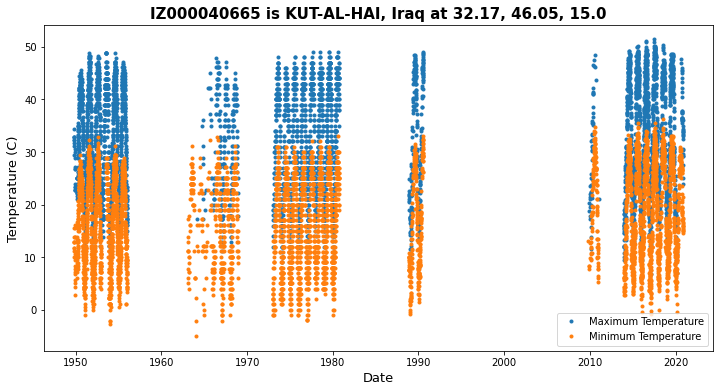

In [ ]:
# Load TMAX data
tmaxArray=ghn.getVar(statDict,'TMAX')
days, tmax = zip(*tmaxArray)

# Load TMIN data
tminArray=ghn.getVar(statDict,'TMIN')
days2, tmin = zip(*tminArray)

# Plot TMIN and TMAX for data
fig = plt.figure(figsize=(12, 6))
plt.plot(days,tmax,'.',label='Maximum Temperature') # Plot Maximum Temperatures
plt.plot(days2,tmin,'.',label='Minimum Temperature') # Plot Minimum Temperatures
plt.legend(loc='best')

# Axes labels
plt.xlabel("Date", fontsize = 13)
plt.ylabel("Temperature (C)", fontsize = 13)
plt.title(ghn.getStation(statNames[whichStat]), fontsize = 15, fontweight = 'bold')

As seen above, the data for this station has many large gaps (assuming `whichStat=472` hasn't been changed) where there are no recorded data points. This presents a large issue if we are to train our network on such a dataset, as we would ideally require a full set of measurements with no holes. For this, we will now have to devise a solution to *clean* our data for predicting.

## Cleaning the Data

### Pandas Dataframe
We can use the `pandas` library to find our missing data points by constructing a dataframe of a chosen metric and its associated days of measurement. We can then use the `resample` function to fill in our gaps in the days (which will be labelled `NaN` in the dataframe) along with `df.interpolate` which will linearly interpolate our missing data for our chosen metric. Also, as we want to also make some predictions on the monthly averages, we can use the `resample('M').mean()` functionality to remodel our data into the monthly averages. The following code is influenced by Week6_pandas.ipynb [1].

In [ ]:
def fill_gaps(days, param):
  '''
  Uses pandas module to find missing dates and accordingly linearly interpolate a parameter associated to each date with the same gaps.
  Also calculates the monthly averages of the parameter recordings.
  '''
  df = pd.DataFrame({'param': param}, index=pd.to_datetime(days))   # Create a pandas dataframe with the input data
  df = df.resample('D').asfreq() # Resample data to daily frequency, filling missing values with NaN

  df = df.interpolate(method='linear') # Linearly interpolate NaN values

  monthly_averages = df.resample('M').mean() # Resample data to monthly frequency and calculate monthly averages

  return df.index.strftime('%Y-%m-%d').tolist(), df['param'].tolist(), monthly_averages.index.strftime('%Y-%m').tolist(), monthly_averages['param'].tolist() # Return as arrays

Using this function, we can observe how it fills the gaps for the station data shown before. Note that the returned `days` arrays from the above function  have to be converted to numpy arrays to be plotted.

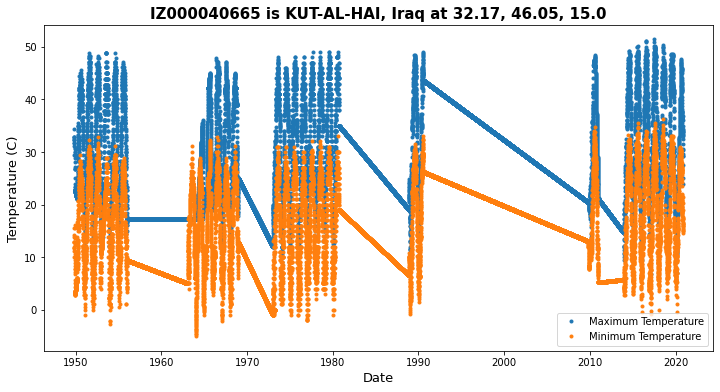

In [ ]:
# Fill gaps for TMAX and TMIN using function
days, tmax, months, monthly_tmax = fill_gaps(days,tmax)
days2, tmin, months2, monthly_tmin = fill_gaps(days2,tmin)

# Produce plot of TMAX and TMIN with linearly interpolated points
fig = plt.figure(figsize=(12, 6))
plt.plot(np.array(days, dtype='datetime64'),tmax,'.',label='Maximum Temperature') # Plot Maximum Temperatures
plt.plot(np.array(days2, dtype='datetime64'),tmin,'.',label='Minimum Temperature') # Plot Minimum Temperatures
plt.xlabel("Date", fontsize = 13)
plt.ylabel("Temperature (C)", fontsize = 13)
plt.title(ghn.getStation(statNames[whichStat]), fontsize = 15, fontweight = 'bold')
plt.legend(loc='best')

Seems like our linear interpolation method doesn't work too well for large gaps, but seems to fill in smaller holes to a much better degree. This means that it could prove to be effective for data without large gaps.

### Processing the Data
Now to create another function that will unpack our chosen parameter's data and use the previously defined `fill_gaps` function to fill the holes. This function also returns how many holes there are in the daily recordings and we will need this for later analysis.

In [ ]:
def process_data(array, param_name, verbose=0):
  '''
  Takes the array containing the dates and associated recordings for a chosen key, unpacks it and cleans the data using 'fill_gaps' function.
  Converts outputs to numpy arrays.
  '''
  days, param = zip(*array) # Retrieve dates and key info
  clean_days, clean_param, months, monthly_param = fill_gaps(days,param) # Fill gaps in data via linear interp.

  # Convert 'cleaned' data into numpy arrays
  clean_days = np.array(clean_days, dtype='datetime64')
  clean_param = np.array(clean_param)
  months = np.array(months, dtype='datetime64')
  monthly_param = np.array(monthly_param)

  # Output how many data points there are and how many have been linearly interpolated
  if verbose == 1:
    print('There is ' + str(len(clean_days)) + ' data points for ' + str(param_name) + ', '+ str(len(clean_days) - len(days)) + ' of which have been linearly interpolated')

  gaps = int(len(clean_days) - len(days)) # The total number of date gaps in the original data

  return days, param, clean_days, clean_param, months, monthly_param, gaps

### Cleaning a Station's Data
The `clean_data` function now utilises the previous two functions to extract the five metrics from a chosen station number, and plots these accordingly. This function is also used to check that all core metrics have been sufficiently measured by the station (at least 5000 measurements) and the recordings are up to date (2020). If these conditions are not met, the function will reject the data, giving an explanation as to why and another station number will need to be chosen.

In [ ]:
def clean_data(station, statNames, show_plot=False, verbose = 0):
  '''
  Takes a station number and statNames dict, loads the data from the keys 'TMAX', 'TMIN', 'PRCP', 'SNWD', 'SNOW' and cleans them using 'process_data' function.
  If data is missing for one of these metrics, or if there is insufficient data for one, or is not up to date (2020), will reject the data and output a reason as to why.
  '''
  # Load station information from associated link
  fileName=statNames[station]+'.dly'
  urlName='http://www.hep.ucl.ac.uk/undergrad/0056/other/projects/ghcnd/ghcnd_gsn/'+fileName

  # Copy a network object to a local file
  urllib.request.urlretrieve(urlName,fileName)
  statDict=ghn.processFile(fileName)

  if all(key in statDict.keys() for key in ['TMAX', 'TMIN', 'PRCP', 'SNWD', 'SNOW']): # Check all core metrics have been recorded

    # Clean maximum temp. (TMAX) data
    tmaxArray=ghn.getVar(statDict,'TMAX')
    days1, tmax, clean_days1, clean_tmax, months1, monthly_tmax, gaps1 = process_data(tmaxArray, 'TMAX', verbose)

    # Clean minimum temp. (TMIN) data
    tminArray=ghn.getVar(statDict,'TMIN')
    days2, tmin, clean_days2, clean_tmin, months2, monthly_tmin, gaps2 = process_data(tminArray, 'TMIN', verbose)

    # Clean rainfall (PRCP) data
    prcpArray=ghn.getVar(statDict,'PRCP')
    days3, prcp, clean_days3, clean_prcp, months3, monthly_prcp, gaps3 = process_data(prcpArray, 'PRCP', verbose)

    # Clean snow depth (SNWD) data
    snwdArray=ghn.getVar(statDict,'SNWD')
    days4, snwd, clean_days4, clean_snwd, months4, monthly_snwd, gaps4 = process_data(snwdArray, 'SNWD', verbose)

    # Clean snowfall (SNOW) data
    snowArray=ghn.getVar(statDict,'SNOW')
    days5, snow, clean_days5, clean_snow, months5, monthly_snow, gaps5 = process_data(snowArray, 'SNOW', verbose)

    if str(clean_days1[-1])[:4] == '2020' and str(clean_days2[-1])[:4] == '2020' and str(clean_days3[-1])[:4] == '2020' and str(clean_days4[-1])[:4] == '2020' and str(clean_days5[-1])[:4] == '2020': # Check data is up to date
      if len(clean_days1) and len(clean_days2) and len(clean_days3) and len(clean_days4) and len(clean_days5) > 5000: # Check there is sufficient data
        print('Station ' + str(station) + ' fulfills the criteria') # Output acceptance
        gaps = gaps1 + gaps2 + gaps3 + gaps4 + gaps5 # Find how 'gappy' the data is
      else: # Not enough data
        print('Station ' + str(station) + ' does not have enough data points for each key') # Reason for rejection
        gaps = 999999 # Maximise gaps
    else: # The data is not up to date
      print('Station ' + str(station) + ' does not have the most up-to-date data for each key') # Reason for rejection
      gaps = 999999 # Maximise gaps

    if show_plot == True: # Produce plots
      plt.rcParams["figure.autolayout"] = True # Ensure the output looks nice
      fig, ax = plt.subplots(5,1, figsize = (20,15))

      # Max Temperature plot
      ax[0].plot(clean_days1,clean_tmax, '.', label = 'interpolated data') # Cleaned data
      ax[0].plot(days1,tmax, '.', label = 'original data') # Original data

      # Associated Labels
      #ax[0].set_xlabel("Date") # Has been commented out for display purposes
      ax[0].set_ylabel("Temperature (C)")
      ax[0].set_title("TMAX at " + str(ghn.getStation(statNames[station]))[:11])
      ax[0].legend()

      # Min Temperature plot
      ax[1].plot(clean_days2,clean_tmin, '.', label = 'interpolated data') # Cleaned data
      ax[1].plot(days2,tmin, '.', label = 'original data') # Original data

      # Associated Labels
      #ax[1].set_xlabel("Date")
      ax[1].set_ylabel("Temperature (C)")
      ax[1].set_title("TMIN at " + str(ghn.getStation(statNames[station]))[:11])
      ax[1].legend()

      # Rainfall plot
      ax[2].plot(clean_days3,clean_prcp, '.', label = 'interpolated data') # Cleaned data
      ax[2].plot(days3,prcp, '.', label = 'original data') # Original data

      # Associated Labels
      #ax[2].set_xlabel("Date")
      ax[2].set_ylabel("Precipitation (mm)")
      ax[2].set_title("Precipitation at " + str(ghn.getStation(statNames[station]))[:11])
      ax[2].legend()

      # Snow Depth plot
      ax[3].plot(clean_days4,clean_snwd, '.', label = 'interpolated data') # Cleaned data
      ax[3].plot(days4,snwd, '.', label = 'original data') # Original data

      # Associated Labels
      #ax[3].set_xlabel("Date")
      ax[3].set_ylabel("Snow Depth (mm)")
      ax[3].set_title("Snow Depth at " + str(ghn.getStation(statNames[station]))[:11])
      ax[3].legend()

      # Snowfall plot
      ax[4].plot(clean_days5,clean_snow, '.', label = 'interpolated data') # Cleaned data
      ax[4].plot(days5,snow, '.', label = 'original data') # Original data

      # Associated Labels
      ax[4].set_xlabel("Date")
      ax[4].set_ylabel("Snow Fall (mm)")
      ax[4].set_title("Snow Fall at " + str(ghn.getStation(statNames[station]))[:11])
      ax[4].legend()

    return clean_days1, clean_tmax, months1, monthly_tmax, clean_days2, clean_tmin, months2, monthly_tmin, clean_days3, clean_prcp, months3, monthly_prcp, clean_days4, clean_snwd, months4, monthly_snwd, clean_days5, clean_snow, months5, monthly_snow, gaps

  else: # Data is missing for a core metric
    print('Station ' + str(station) + ' is missing data for one of the keys') # Output reason for rejection
    gaps = 999999 # Maximise gap so won't be returned when looking for minimum
    clean_days1, clean_tmax, months1, monthly_tmax, clean_days2, clean_tmin, months2, monthly_tmin, clean_days3, clean_prcp, months3, monthly_prcp, clean_days4, clean_snwd, months4, monthly_snwd, clean_days5, clean_snow, months5, monthly_snow = [0] * 20 # To ensure return statement works
    return clean_days1, clean_tmax, months1, monthly_tmax, clean_days2, clean_tmin, months2, monthly_tmin, clean_days3, clean_prcp, months3, monthly_prcp, clean_days4, clean_snwd, months4, monthly_snwd, clean_days5, clean_snow, months5, monthly_snow, gaps



### Finding the Best Station
As we saw before, some stations have data that is just too gappy for us to interpolate the missing points accurately. To combat this, the code below uses the `clean_data` function in order to find the best station, defined as one where:
- All metrics have been measured
- There is sufficient data for each metric's recordings (at least 5000 points)
- It has the least number of holes for the measurements of each metric compared to the others
- The data is up to date, with the last measurement being in 2020.

A station with a really small number of holes in the dataset allows our linear interpolation method to be valid, as the maximum size of a gap is likely to be 1 day, and the number of interpolated points will be negligible compared to the number of real measurements, having little to no impact on the trends shown in the data.

The cell below takes a really long time to run and so the output-producing line has been commented out. Un-comment the last two lines to see the process of determining the 'best' station.

In [ ]:
# THIS CODE CELL WAS USED TO FIND THE BEST STATION DATA AND TAKES A VERY LONG TIME TO RUN
def find_best_station():
  '''
  Uses the clean_data function to find the best weather station via iteration
  based on the number of gaps, number of data points and data recency.
  '''
  all_gaps = [] # Initialise array for holes

  # Over all stations find gaps and update array
  for i in range(990):
    days1, tmax, months1, monthly_tmax, days2, tmin, months2, monthly_tmin, days3, prcp, months3, monthly_prcp, days4, snwd, months4, monthly_snwd, days5, snow, months5, monthly_snow, gaps = clean_data(i, statNames, show_plot=False, verbose=0)
    all_gaps.append(gaps) # Update array with number of gaps
  return all_gaps

# Un-comment the following two lines to see how the best stations were determined
#all_gaps = find_best_station() # Assess each station against criteria and get array of gaps
#print(np.argsort(all_gaps)[:15]) # Find the indexes of the 15 stations with the lowest number of gaps

The cell above returns the following array:

[954 931 918 959 938 894 946 902 937 897 905 958 926 379 929]

These are the 15 stations that best fit the above criteria.

### The Best Station Data
Although the best station is technically number 954, it was found (by changing the first argument of clean_data) that this station does not experience much, if any snowfall, leaving the majority of the measurements for **SNOW** and **SNWD** as 0. As we are investigating how well our model can predict data, another one of the stations from this list has been chosen as the gap number does not increase by much (less than 5 across all metrics), and there is more complex data for each metric. The data from this chosen station has been outputted below using the `clean_data` function.

USW00024023 is NORTH PLATTE RGNL AP, United States at 41.1214, -100.6694, 846.7
There is 26617 data points for TMAX, 0 of which have been linearly interpolated
There is 26617 data points for TMIN, 0 of which have been linearly interpolated
There is 26617 data points for PRCP, 1 of which have been linearly interpolated
There is 26617 data points for SNWD, 3 of which have been linearly interpolated
There is 26617 data points for SNOW, 5 of which have been linearly interpolated
Station 931 fulfills the criteria


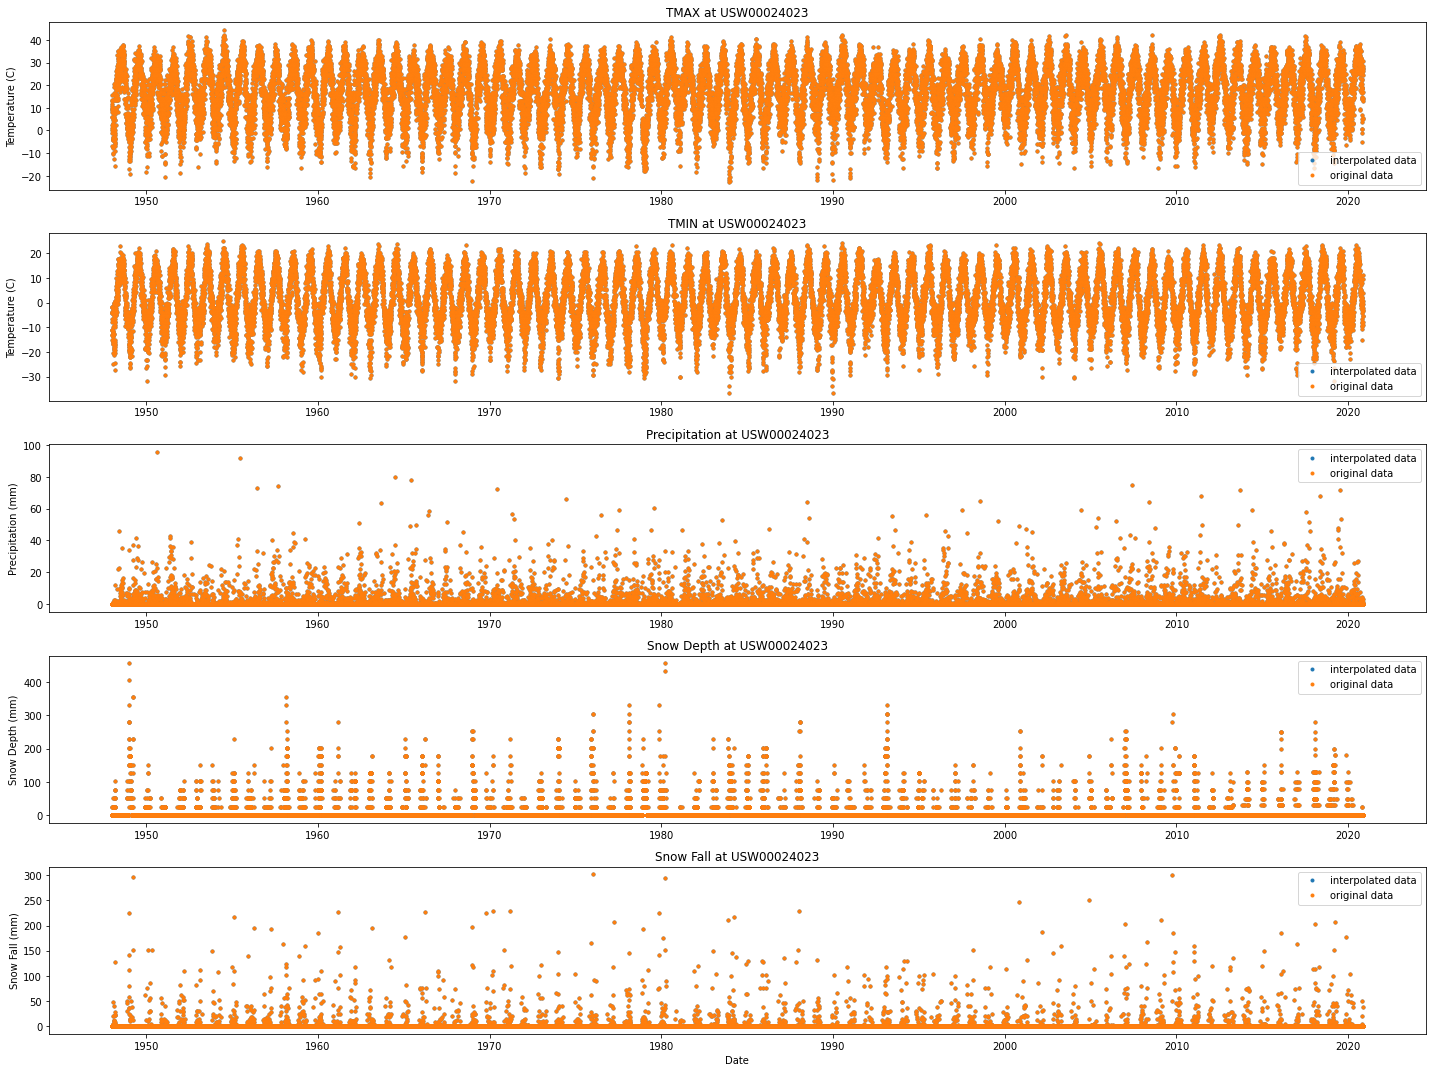

In [ ]:
print(ghn.getStation(statNames[931])) # Output name of chosen station
# Clean data and produce plots of metrics from chosen best station
days1, tmax, months1, monthly_tmax, days2, tmin, months2, monthly_tmin, days3, prcp, months3, monthly_prcp, days4, snwd, months4, monthly_snwd, days5, snow, months5, monthly_snow, gaps = clean_data(931, statNames, show_plot=True, verbose=1)

In [ ]:
print('The number of data points in the climate data is: ' + str(len(months1))) # How many data points in climate

The number of data points in the climate data is: 875


## Predicting the Weather and Climate 1 Year Into the Future

### Data Normalisation
Now that we have achieved a full dataset for each parameter through cleaning the data, we can prepare our data for predicting by normalising it. Normalisation is important here because our dataset is very complex, and so normalising the values may lead our network to have a potentially increased performance, faster convergence, lowered cost and improved accuracy.

The normalisation technique that we will use is min-max scaling, where the resultant values will be between 0 and 1. We will also need another function that will reverse this operation when we receive our predicted values so we can see the true values of the temperatures, rainfall, snowfall and snow depth that it returns.

In [ ]:
def normalise(data):
  '''
  Uses min-max scaling to normalise input data
  '''
  # Find the minimum and maximum values of the input data
  data_min = np.min(data)
  data_max = np.max(data)

  # Calculate scaling factor and scaled data
  scale_factor = 1 / (data_max - data_min)
  normalised_data = (data - data_min) * scale_factor

  return normalised_data


def reverse_normalise(normalised_data, original_data):
  '''
  Reverses min-max scaling to return true values from normalised data
  '''
  # Find the min and max of original data
  data_min = np.min(original_data)
  data_max = np.max(original_data)

  # Calculate scaling factor and reversed data
  scale_factor = 1 / (data_max - data_min)
  reversed_data = normalised_data / scale_factor + data_min

  return reversed_data

# Test that the functions are working on exemplary tmax
print("The original data points are: " + str(tmax))
print("The normalise function returns: " + str(normalise(tmax)))
print("Reversing the normalisation gives: " + str(reverse_normalise(normalise(tmax),tmax)))


The original data points are: [ 0.   8.3 12.8 ...  5.  14.4 13.9]
The normalise function returns: [0.33928571 0.46279762 0.5297619  ... 0.41369048 0.55357143 0.54613095]
Reversing the normalisation gives: [ 0.   8.3 12.8 ...  5.  14.4 13.9]


Great, our `normalise` and `reverse_normalise` functions are working as intended.

### Prediction Functions
Now we are ready to make some predictions on our dataset, but first we need a way of splitting our data into *inputs* and their associated *labels* for our network to successfully train on it. The `shapeArray` function below does exactly that, splitting our dataset such that a model is able to be trained on it. (Taken from Week_6_Exercise.ipynb [2])

In [ ]:
def shapeArray(x,windowsize,offset):
  """
  Splits up a 1-d array x into a series of overlapping windows.
  Returns a tuple of the array of input windows and target (label) windows
  """
  first_point=len(x)-(windowsize+offset)
  xInput = np.array([x[i : i + windowsize] for i in range(first_point)]) # Generate input windows
  xLabel = np.array([x[i+ windowsize+offset] for i in range(first_point)]) # Generate target windows
  return (xInput,xLabel)

With this defined, we are ready to create a function which will hopefully predict the future weather of our station. Firstly, the data needs to be split up into training, validation and testing sets. Then we can create our network including at least 1 LSTM layer, and train it on the training and validation sets, assessing the loss functions. Finally, using our testing set, we can predict some *windowsize + offset* data points into the future for each of our metrics.

Below, we have defined a function named `predict` which performs exactly this. On top of this, it takes arguments `stacked`, `normalised` and `avgs` for later investigatory purposes to find the best method of prediction.

- `stacked` - Checks if the input data is a single array (`=False`) of one metric or is a matrix of multiple metrics' data (`=True`)
- `normalised` - Checks if the input data is normalised (`=True`) or not (`=False`) in order to un-normalise the prediction output.
- `avgs` - Checks for if the input data is the daily weather (`=False`) or is of the monthly averages (`=True`)

In [ ]:
def predict(windowsize,offset,data,stacked=False,normalised=False,avgs=False):
  '''
  Creates a model with an LSTM layer of 64 neurons to be trained on a matrix of the input
  metric recordings, either daily or monthly averaged. Returns the training loss and validation loss
  as well as the predictions for each metric some windowsize+offset data points into the future
  of the testing set.
  '''
  global tmax,tmin,prcp,snwd,snow # Used to reverse normalise predictions

  # Check for request of normalisation
  if normalised==True:
    orig_data = data # Store non-normalised data
    data = normalise(data) # Normalise data

  if avgs == True: # Split monthly averages into training, validation and test sets
    train_data = data[:-336]
    valid_data = data[-336:-168]
    test_data = data[-168:]
  else: # Split daily recordings into training, validation and test sets
    train_data = data[:-10000]
    valid_data = data[-10000:-5000]
    test_data = data[-5000:]

  # Get input and target windows for each set
  train_inputs, train_outputs = shapeArray(train_data, windowsize, offset)
  valid_in, valid_out = shapeArray(valid_data, windowsize, offset)
  test_in, test_out = shapeArray(test_data, windowsize, offset)

  # Change the model's input shape relating to the number of metrics being predicted
  if stacked == True:
    in_shape = 5
  else:
    in_shape = 1

  # Define model with 1 LSTM layer of 64 neurons and 4 dense layers of chosen shapes
  model = keras.models.Sequential()
  model.add(keras.layers.LSTM(64,input_shape=(None,in_shape),return_sequences=False))
  model.add(keras.layers.Dense(64,activation='relu'))
  model.add(keras.layers.Dense(32,activation='relu'))
  model.add(keras.layers.Dense(16,activation='relu'))
  model.add(keras.layers.Dense(in_shape,activation="linear"))
  model.compile(loss='mean_squared_error',optimizer='adam') # Compile network

  # Train on training set with validation for either monthly averages (avgs == True) or daily
  if avgs == True:
    history = model.fit(train_inputs, train_outputs, batch_size = 64, epochs=50, verbose=0, validation_data = (valid_in, valid_out))
  else:
    history = model.fit(train_inputs, train_outputs, batch_size = 96, epochs=15, verbose=0, validation_data = (valid_in, valid_out))

  preds = model.predict(test_in) # Make prediction

  # Plot training and validation loss functions
  fig = plt.figure(figsize=(8, 5))
  plt.plot(history.history['loss'], label='Training Loss') # Training Loss
  plt.plot(history.history['val_loss'], label='Validation Loss') # Validation Loss
  plt.legend(loc='best')
  plt.xlabel('Epoch', fontsize = 13)
  plt.ylabel('Cost', fontsize = 13)
  # Change title according to monthly or daily data
  if avgs == True:
    plt.title('Monthly Averaged Training and Validation Losses', fontsize = 15, fontweight='bold')
  else:
    plt.title('Daily Measurements Training and Validation Losses', fontsize = 15, fontweight='bold')

  if stacked == True: # If data is a matrix
    # Re-split matrix into metrics data
    if normalised == True: # Get original values from normalised predictions
      tmax_pred = reverse_normalise(preds[:,0 ],tmax)
      tmin_pred = reverse_normalise(preds[:,1 ],tmin)
      prcp_pred = reverse_normalise(preds[:,2 ],prcp)
      snwd_pred = reverse_normalise(preds[:,3 ],snwd)
      snow_pred = reverse_normalise(preds[:,4 ],snow)
    else: # Data does not need to be reverse normalised
      tmax_pred = preds[:,0 ]
      tmin_pred = preds[:,1 ]
      prcp_pred = preds[:,2 ]
      snwd_pred = preds[:,3 ]
      snow_pred = preds[:,4 ]

    return tmax_pred, tmin_pred, prcp_pred, snwd_pred, snow_pred

  else: # Data is not a matrix
    if normalised == True: # Reverse normalise data if it has been normalised
      return(reverse_normalise(preds,orig_data))
    else: # Does not need to be reverse normalised
      return preds

### Preliminary Evaluation
Ultimately, we want our model to be able to successfully do the following:

1. Predict the monthly averaged weather (defined as the climate) a year in advance.
2. Predict the daily weather, ideally better than assuming that the weather today will be the same as it was yesterday (i.e. shifting each data point by 1 day).

For the second objective, the function `same_as_yesterday` has been defined below that will take our recordings and apply the assumption to it.

In [ ]:
def same_as_yesterday(arr):
  '''
  Shifts the indexes of some array 'arr' by 1 as to assume that the weather today will be the same as yesterday.
  '''
  shift = np.roll(arr,1) # Shift indexes by 1, moves final index to first position

  # Return first index back to final position
  shift[0] = arr[-1]
  return np.concatenate(([arr[-1]], shift[1:])) # Merge

Now to produce a function that will plot the predictions for the climate and daily weather over the original data, and also zooms in on a section of the weather prediction to assess how good our predictions are compared to the 'same as yesterday' assumption.

In [ ]:
def prediction_plots(days, param, param_pred, months, monthly_param, monthly_param_pred, ylabel, daily = False):
  '''
  Produces plots of original data vs predicted data including climate, daily weather and comparison of daily weather to
  'same as yesterday' prediction.
  '''
  plt.rcParams["figure.autolayout"] = True # Ensure the output looks nice

  if daily == False: # Climate data only
    fig = plt.figure(figsize=(20,4)) # Produce plot figure
    plt.plot(months[-168:],monthly_param[-168:], label='Original (Interpolated) Data') # Plot original climate data
    plt.plot(months[-len(monthly_param_pred):], monthly_param_pred, label = 'Prediction') # Plot predicted climate data

    # Associated Graph Labels
    plt.xlabel('Date', fontsize = 13)
    plt.ylabel('' + str(ylabel), fontsize = 13)
    plt.title('Predicted Climate (Monthly)', fontsize = 15, fontweight = 'bold')
    plt.legend()

  else: # Plot climate, daily and compared assumption predictions
    fig, ax = plt.subplots(3,1, figsize = (20,10))

    # Plot climate
    ax[0].plot(months[-168:],monthly_param[-168:], label='Original (Interpolated) Data') # Original climate data
    ax[0].plot(months[-len(monthly_param_pred):], monthly_param_pred, label = 'Prediction') # Predicted climate data

    # Associated Labels
    ax[0].set_ylabel('' + str(ylabel), fontsize = 13)
    ax[0].set_title('Predicted Climate (Monthly)', fontsize = 15, fontweight = 'bold')
    ax[0].legend()

    ax[1].plot(days[-5000:], param[-5000:], label = 'Original (Interpolated) Data') # Original daily weather
    ax[1].plot(days[-len(param_pred):],param_pred, label = 'Prediction') # Predicted daily weather

    # Associated Labels
    ax[1].set_ylabel('' + str(ylabel), fontsize = 13)
    ax[1].set_title('Daily Predicted Weather', fontsize = 15, fontweight = 'bold')
    ax[1].legend()

    # Plot zoom in of daily weather predictions vs original vs 'same as yesterday' assumption
    ax[2].plot(days[-4500:-4300], param[-4500:-4300], label = 'Original (Interpolated) Data') # Original daily weather
    ax[2].plot(days[-4500:-4300], same_as_yesterday(param)[-4500:-4300], label = 'Weather Same as Yesterday') # Same as yesterday assumption
    ax[2].plot(days[-4500:-4300], param_pred[-4500:-4300], label = 'Prediction') # Predicted daily weather

    # Associated Labels
    ax[2].set_xlabel('Date', fontsize = 13)
    ax[2].set_ylabel('' + str(ylabel), fontsize = 13)
    ax[2].set_title('Daily Predicted Weather vs Same As Yesterday Prediction', fontsize = 15, fontweight = 'bold')
    ax[2].legend()

#### Predicting Together vs Predicting Independently
As we mentioned earlier, we want to see if training and predicting on all metrics at once yields a better output over training and predicting on each metric individually. We'll first define a function which will tell us which method has the lowest deviation from the original data, before using the `predict` and `prediction_plots` function to show how good the predictions are via each method on **TMAX** and **PRCP**. Then we can call upon the `which_method` function to compare them. Using the results, we will make the assumption that the predictions for **TMIN** and **SNWD** will follow the same pattern as **TMAX** with **SNOW** following the same pattern as **PRCP**.

In [ ]:
def which_method(param, method1_pred, method2_pred, diff):
  '''
  Compares the predictions from two methods against the original data to find
  which one has the lowest total deviation.
  '''
  # Initialise residual values
  deviation_method1 = 0
  deviation_method2 = 0

  # Find deviations from each method
  for i in range(diff):
    deviation_method1 += abs(method1_pred[i]-param[-(diff-i)])
    deviation_method2 += abs(method2_pred[i]-param[-(diff-i)])

  # Which method has a lower deviation
  if deviation_method1 > deviation_method2:
    print("The second method is better with a total deviation of " + str(deviation_method2) + ', better than the first method by ' + str(deviation_method2-deviation_method1))
  elif deviation_method2 > deviation_method1:
    print("The first method is better with a total deviation of " + str(deviation_method1) + ', better than the second method by ' + str(deviation_method1-deviation_method2))

  else: # Required in case both methods return the same deviation
    print("Both methods return the same value")

Stacked Training and Predicting:

4/4 [==============================] - 0s 9ms/step


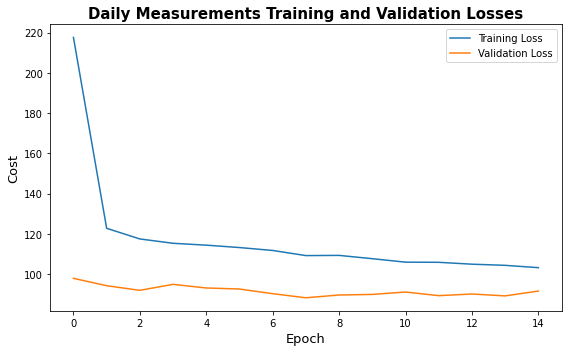

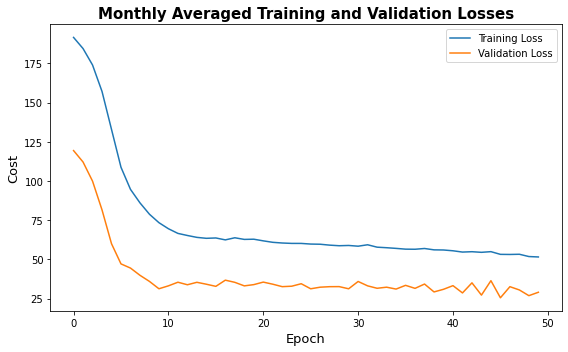

In [ ]:
# Stack daily weather and climate readings together
daily_data = np.stack([tmax,tmin,prcp,snwd,snow]).T # Daily weather
monthly_data = np.stack([monthly_tmax,monthly_tmin,monthly_prcp,monthly_snwd,monthly_snow]).T # Monthly Averages

# Predict 1 year into the future
tmax_pred1,tmin_pred1,prcp_pred1,snwd_pred1,snow_pred1= predict(4,1,daily_data,stacked=True,normalised=False,avgs=False) # Predict daily weather
monthly_tmax_pred1, monthly_tmin_pred1, monthly_prcp_pred1, monthly_snwd_pred1, monthly_snow_pred1 = predict(36,12,monthly_data,stacked=True,normalised=False,avgs=True) # Predict climate

Individual Training and Prediction for **TMAX**:

4/4 [==============================] - 1s 12ms/step


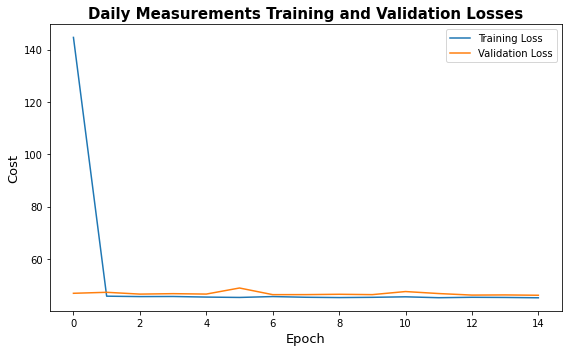

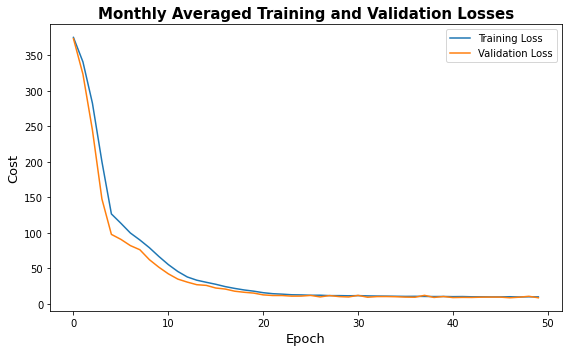

In [ ]:
tmax_pred2 = predict(4,1,tmax) # Daily weather prediction
monthly_tmax_pred2 = predict(36,12,monthly_tmax,avgs=True) # Monthly average prediction

Individual Training and Prediction for **PRCP**:

4/4 [==============================] - 1s 9ms/step


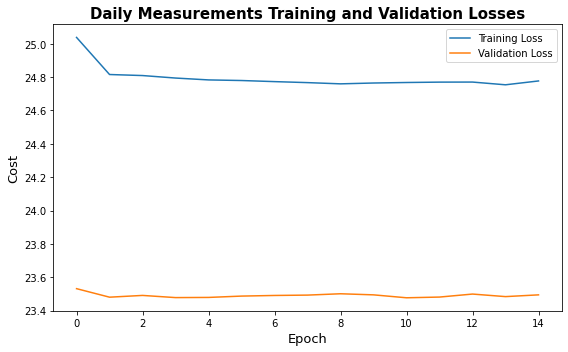

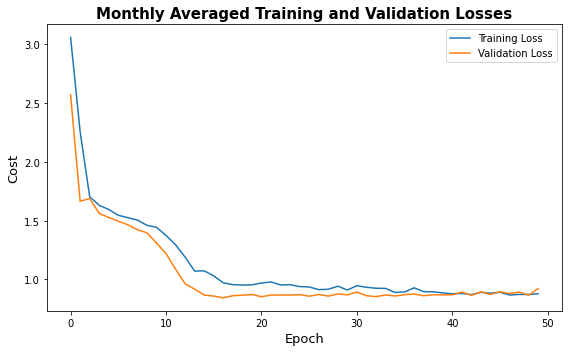

In [ ]:
prcp_pred2 = predict(4,1,prcp) # Daily weather prediction
monthly_prcp_pred2 = predict(36,12,monthly_prcp,avgs=True) # Monthly average prediction

Find whether predicting the daily and monthly **TMAX** is done better through stacking (*method 1*) or individually (*method 2*).

In [ ]:
which_method(tmax,tmax_pred1, tmax_pred2, 4995) # Compare daily TMAX predictions
which_method(monthly_tmax, monthly_tmax_pred1, monthly_tmax_pred2, 120) # Compare monthly  PRCP predictions

The first method is better with a total deviation of 25318.970879022723, better than the second method by [-941.78906]
The second method is better with a total deviation of [280.6001], better than the first method by [-27.890411]


Find whether predicting the daily and monthly **PRCP** is done better through stacking (*method 1*) or individually (*method 2*)

In [ ]:
which_method(prcp,prcp_pred1, prcp_pred2, 4995) # Compare daily PRCP predictions
which_method(monthly_prcp, monthly_prcp_pred1, monthly_prcp_pred2, 120) # Compare monthly PRCP predictions

The second method is better with a total deviation of [12280.171], better than the first method by [-309.13574]
The second method is better with a total deviation of [98.599365], better than the first method by [-12.633728]


So it seems that predicting the metrics together (stacked) would yield better results for the daily **TMAX** and **PRCP** (although this is not by much and is subject to change upon kernel refresh). Both metrics' climates are better predicted individually and show less evidence of overfitting.

Now it remains to see if normalising our data points will have any significant effect on the predictions.

#### Investigating Normalisation
Here, we will just repeat the previous methodology but normalise the inputs to the `predict` function to see if the predictions are any better.

For **TMAX**:

4/4 [==============================] - 1s 11ms/step


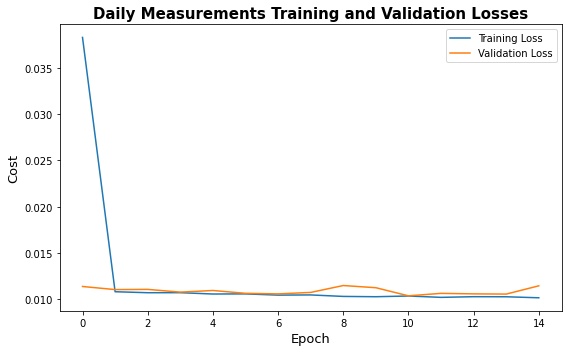

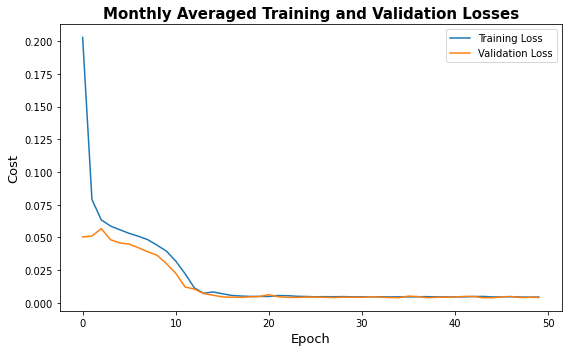

In [ ]:
tmax_pred3 = predict(4,1,tmax,stacked=False,normalised=True,avgs=False) # Predict on normalised daily TMAX
monthly_tmax_pred3 = predict(36,12,monthly_tmax,stacked=False,normalised=True,avgs=True) # Predict on normalised TMAX climate

In [ ]:
which_method(tmax,tmax_pred1, tmax_pred3, 4995) # Compare stacked daily TMAX predictions to normalised
which_method(monthly_tmax, monthly_tmax_pred2, monthly_tmax_pred3, 120) # Compare monthly TMAX predictions to normalised

The first method is better with a total deviation of 25318.970879022723, better than the second method by [-3603.9922]
The first method is better with a total deviation of [280.6001], better than the second method by [-3.8391113]


Normalisation does not seem to be beneficial when predicting the daily **TMAX** but produces a lower total deviation when predicting the climate (again subject to change upon kernel refresh)

And for **PRCP**:

4/4 [==============================] - 1s 9ms/step


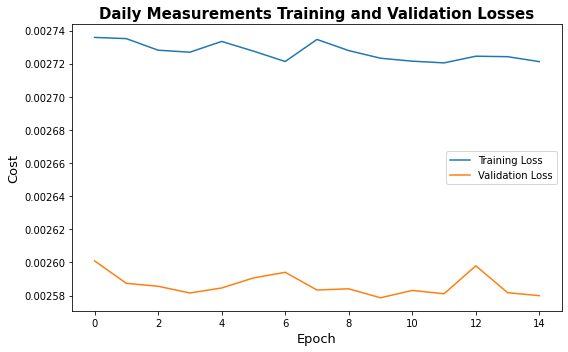

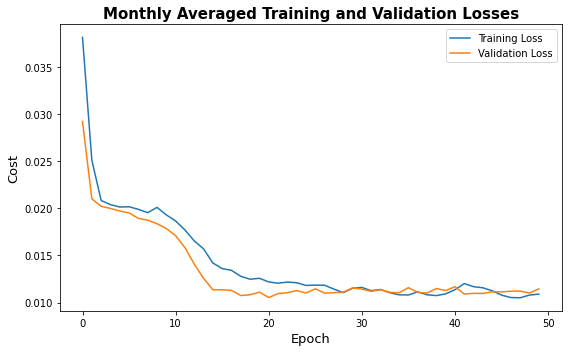

In [ ]:
prcp_pred3 = predict(4,1,prcp,stacked=False,normalised=True,avgs=False) # Predict on normalised daily PRCP
monthly_prcp_pred3 = predict(36,12,monthly_prcp,stacked=False,normalised=True,avgs=True) # Predict on normalised PRCP climate

In [ ]:
which_method(prcp,prcp_pred1, prcp_pred3, 4995) # Compare stacked daily PRCP to normalised
which_method(monthly_prcp, monthly_prcp_pred2, monthly_prcp_pred3, 120) # Compare individual PRCP climate to normalised

The second method is better with a total deviation of [12373.219], better than the first method by [-216.08789]
The first method is better with a total deviation of [98.599365], better than the second method by [-6.0751877]


So it seems the best method for predicting the daily **TMAX** (and **TMIN** + **SNWD**) aligns with the most ideal method of predicting **PRCP** (and therefore **SNOW**). This is via a stacked prediction whereas the monthly averages are individually predicted and normalised.

### Visualisation
Now that we have established a way to achieve the optimal predictions, we can apply these to all other metrics and plot the predictions for each, as done below.

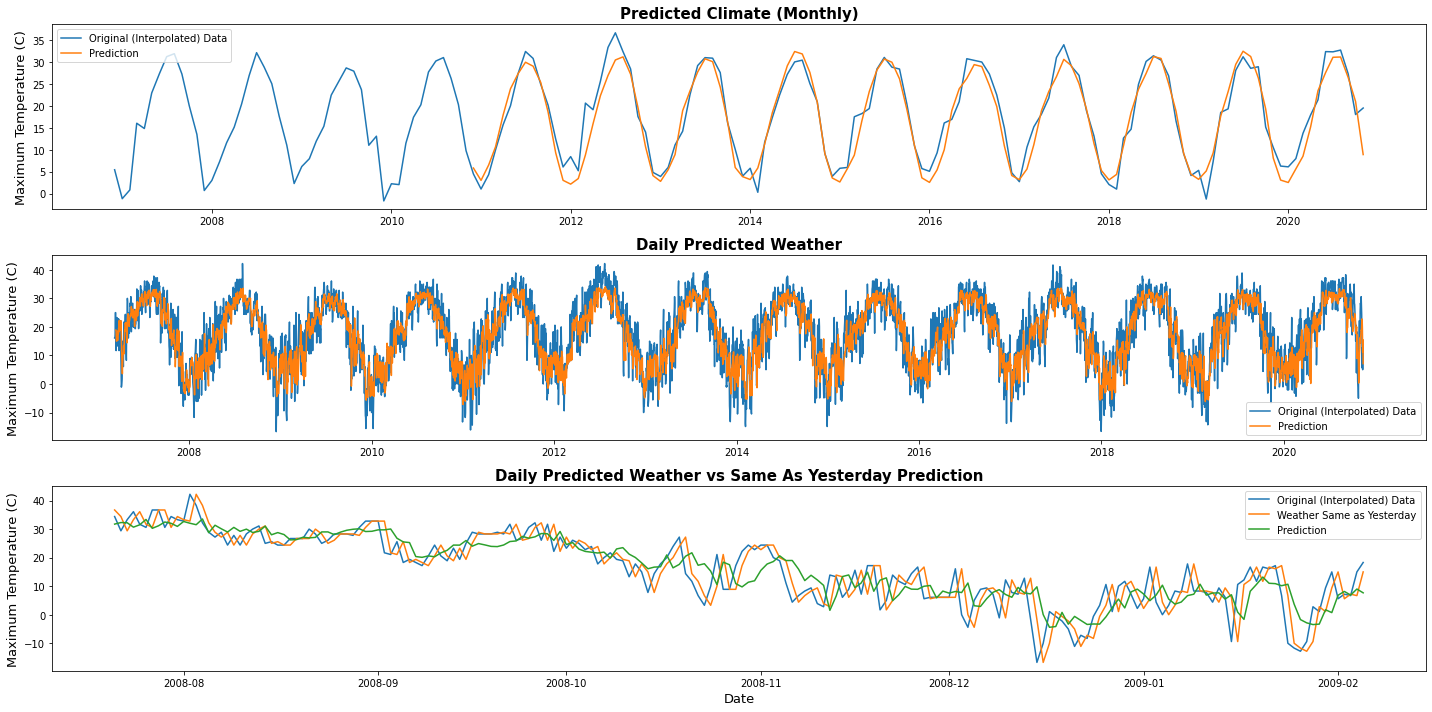

In [ ]:
prediction_plots(days1,tmax,tmax_pred1,months1,monthly_tmax,monthly_tmax_pred3,'Maximum Temperature (C)',daily=True) # Plot TMAX Predictions

4/4 [==============================] - 1s 10ms/step


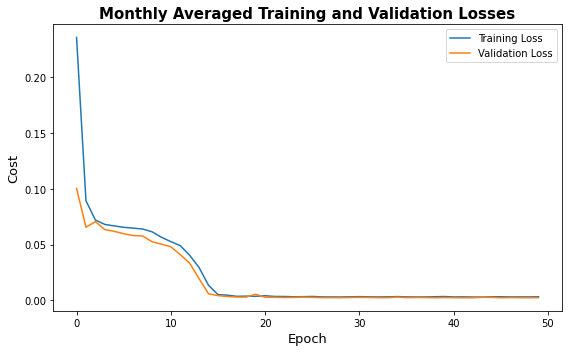

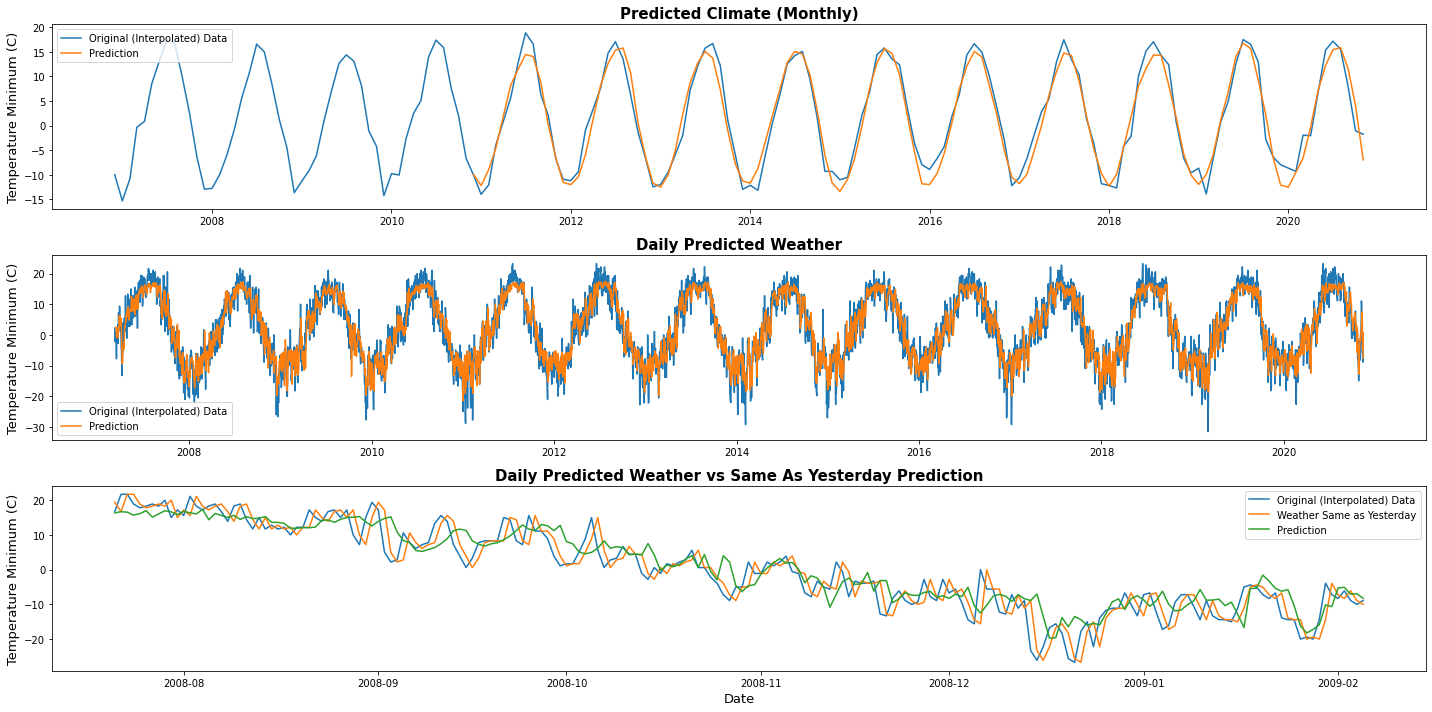

In [ ]:
monthly_tmin_pred = predict(36,12,monthly_tmin,avgs=True,normalised=True) # Monthly TMIN average prediction
prediction_plots(days2,tmin,tmin_pred1,months2,monthly_tmin,monthly_tmin_pred,'Temperature Minimum (C)',daily=True) # Plot TMIN predictions

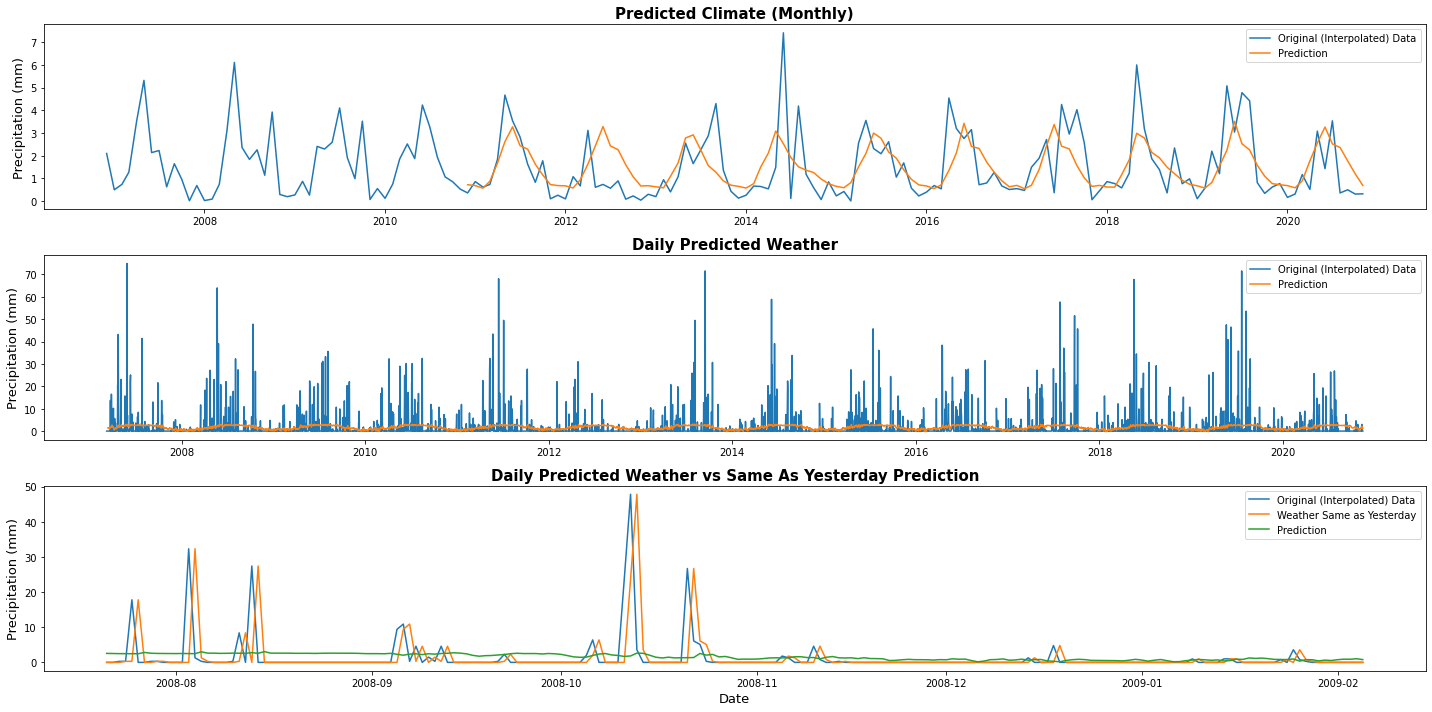

In [ ]:
prediction_plots(days3,prcp,prcp_pred1,months3,monthly_prcp,monthly_prcp_pred3,'Precipitation (mm)',daily=True) # Plot PRCP predictions

4/4 [==============================] - 1s 10ms/step


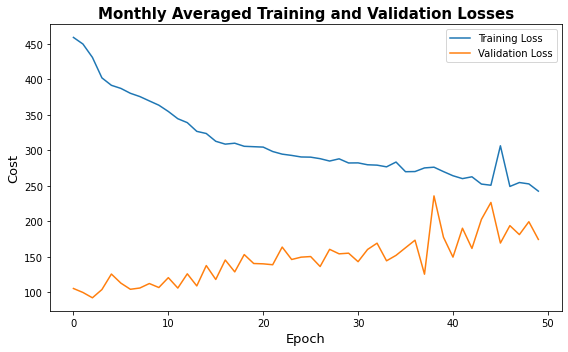

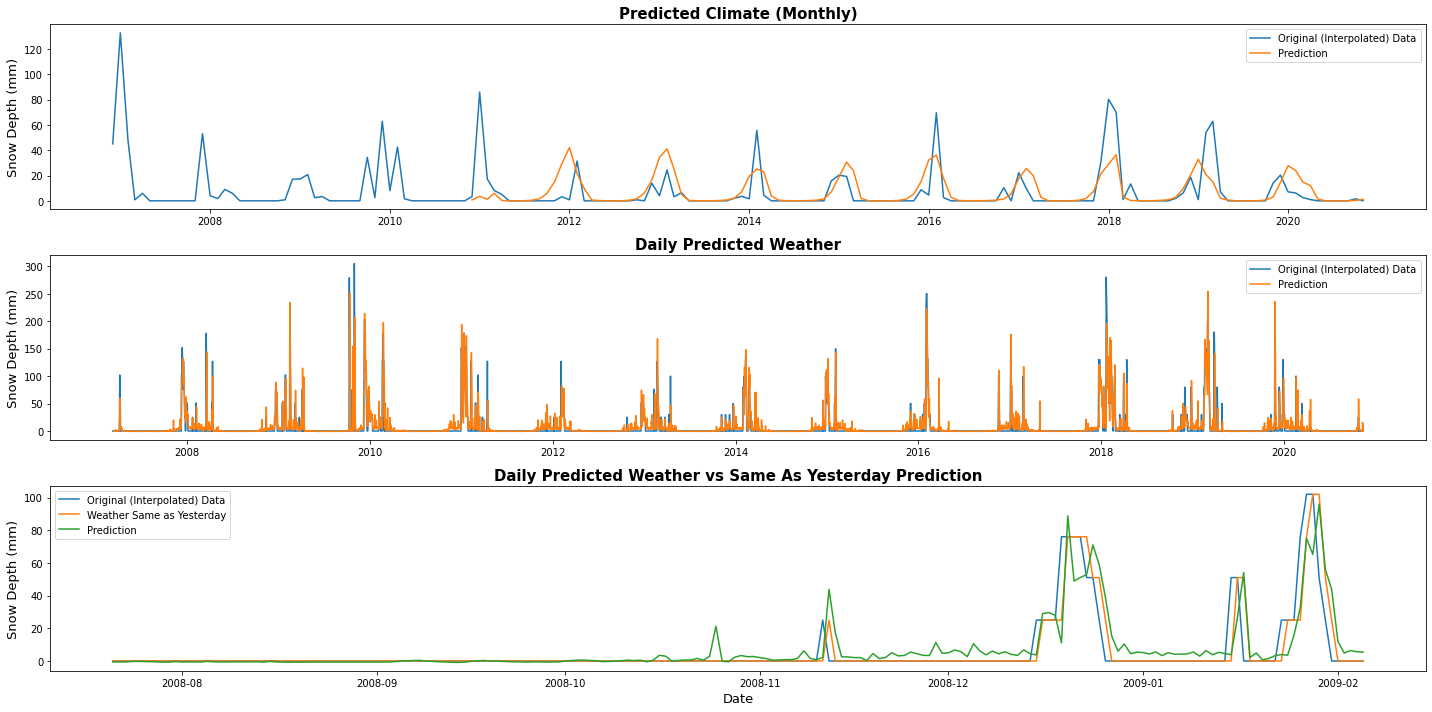

In [ ]:
monthly_snwd_pred = predict(36,12,monthly_snwd,avgs=True) # Predict climate of SNWD
prediction_plots(days4,snwd,snwd_pred1,months4,monthly_snwd,monthly_snwd_pred,'Snow Depth (mm)',daily=True) # Plot SNWD predictions

4/4 [==============================] - 1s 10ms/step


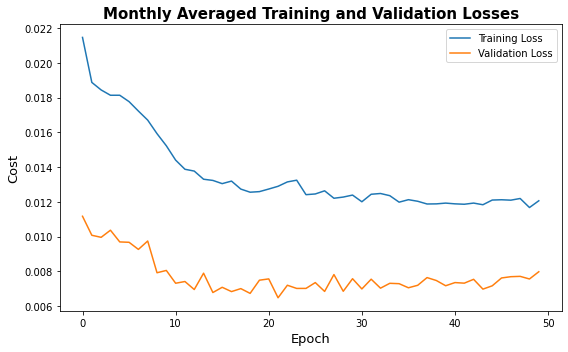

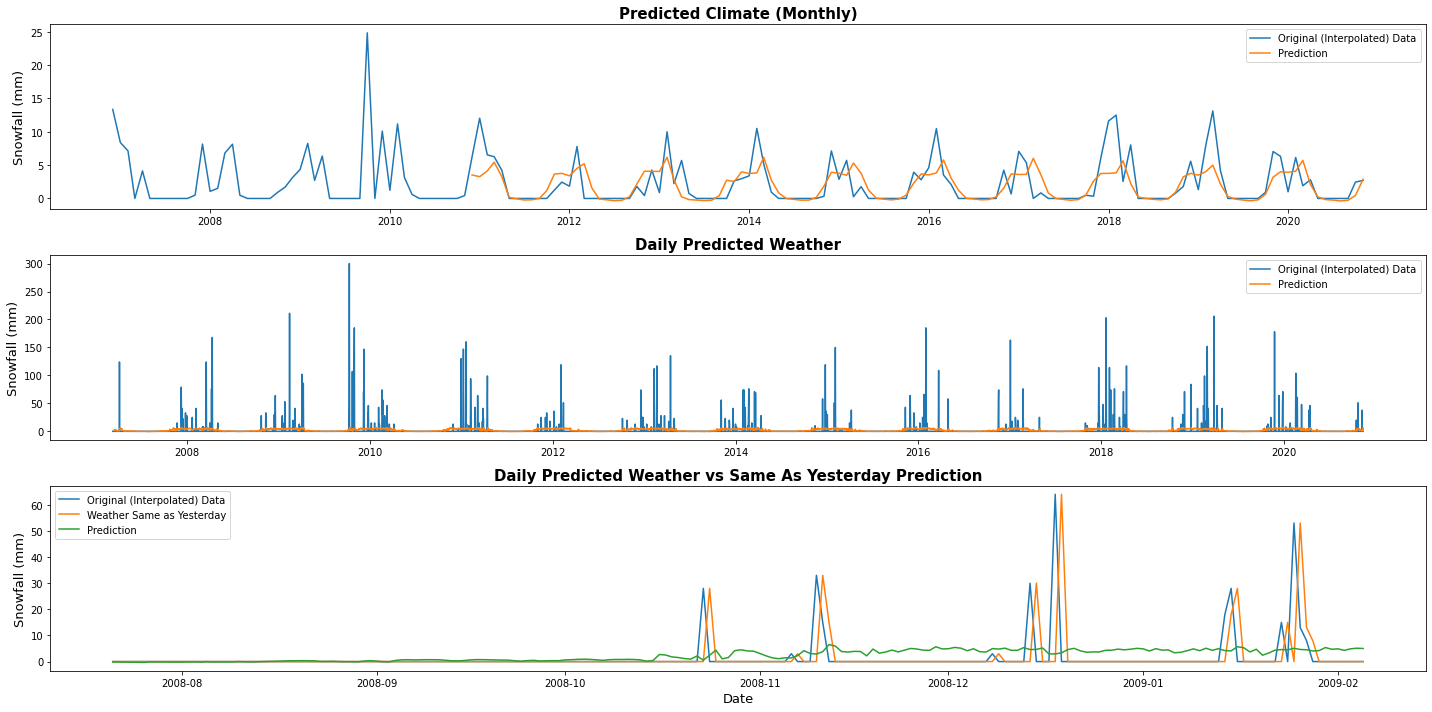

In [ ]:
monthly_snow_pred = predict(36,12,monthly_snow,avgs=True,normalised=True) # Predict SNOW climate
prediction_plots(days5,snow,snow_pred1,months5,monthly_snow,monthly_snow_pred,'Snowfall (mm)',daily=True) # Plot SNOW predictions

### Conclusions
**Climate Predictions**
- ***TMAX*** and ***TMIN*** have successful predictions although some peaks are missed into the future
- ***PRCP***, ***SNWD*** and ***SNOW*** have predictions that are able to tell which months may be subject to such weather events but are not accurate in amplitude.

**Weather Predictions**
- ***TMAX, TMIN*** and ***SNWD*** all have reasonable predictions, lying in the proximity of the original data points, although these are tpyically not better than the 'same as yesterday' prediction. ***SNWD*** although innacurately predicts some days with non-zero snow depth.
- ***PRCP*** and ***SNOW*** have poor predictions, where the peaks are not met but small pertubations in the predicted line may indicate the presence of such weather events. The assumption is better.

## Predicting 10 Years Into the Future (Independent Extension)
If our network is unable to predict the weather accurately one day in advance, it would seem highly unlikely that it would perform any better 3650 days into the future, and a prediction 10 years into the future would be most appropriate for the climate only. If we are to predict the climate 10 years into the future, we must change our offset to 120 (the number of months within this time period). This ensures that the first predicted data point is at least 10 years into the future from the original data it is predicting from. We will now investigate how well our prediction method performs for each metric, as done before.

### TMAX

1/1 [==============================] - 1s 525ms/step


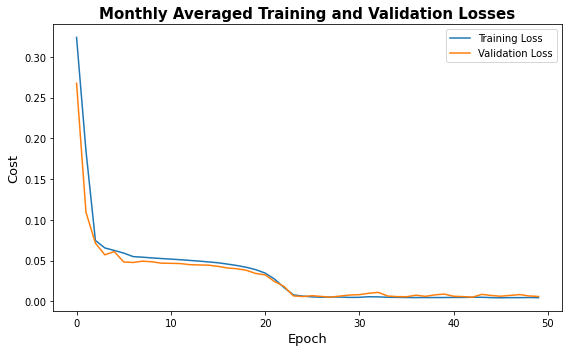

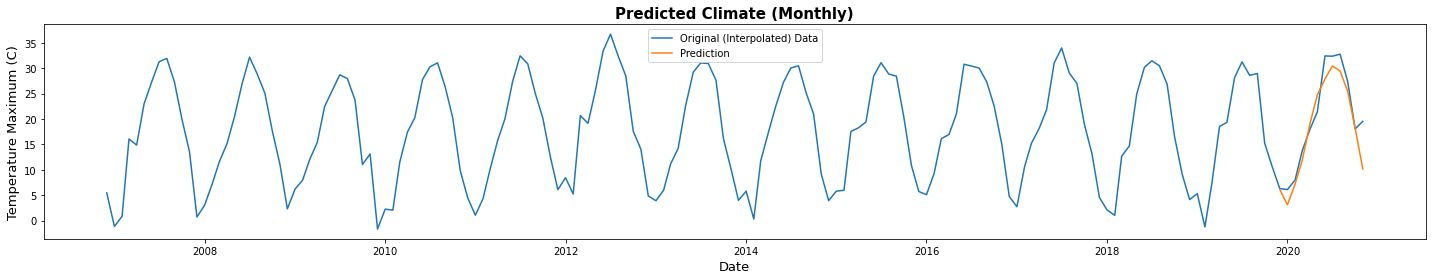

In [ ]:
monthly_tmax_pred2 = predict(36,120,monthly_tmax,avgs=True,normalised=True) # TMAX climate prediction in 10 years
prediction_plots(days1,tmax,tmax_pred2,months1,monthly_tmax,monthly_tmax_pred2,'Temperature Maximum (C)') # Prediction plots

### TMIN

1/1 [==============================] - 1s 503ms/step


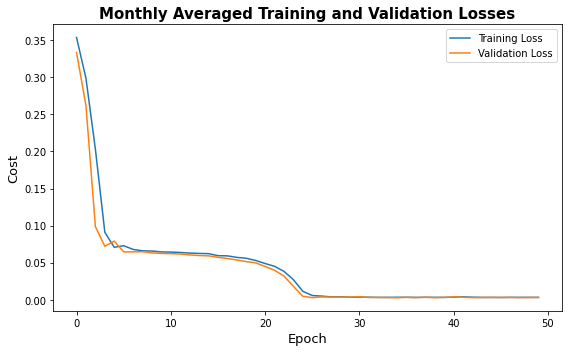

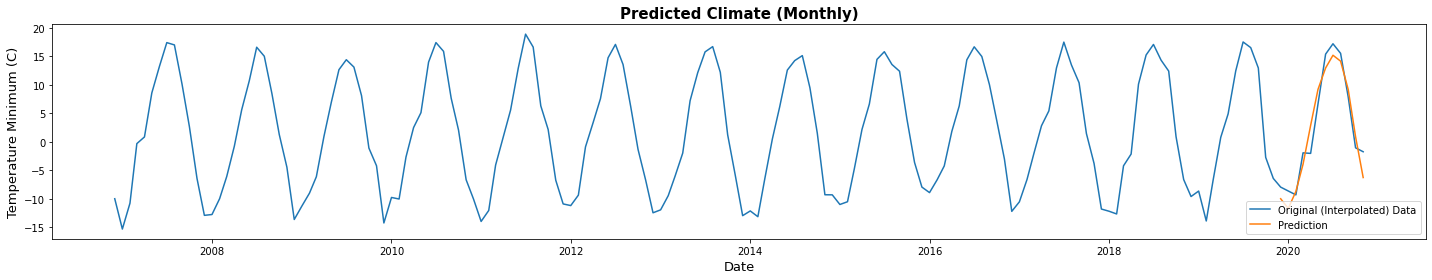

In [ ]:
monthly_tmin_pred2 = predict(36,120,monthly_tmin,avgs=True,normalised=True) # TMIN climate prediction in 10 years
prediction_plots(days2,tmin,tmin_pred1,months2,monthly_tmin,monthly_tmin_pred2,'Temperature Minimum (C)') # Prediction plots

### PRCP

1/1 [==============================] - 1s 533ms/step


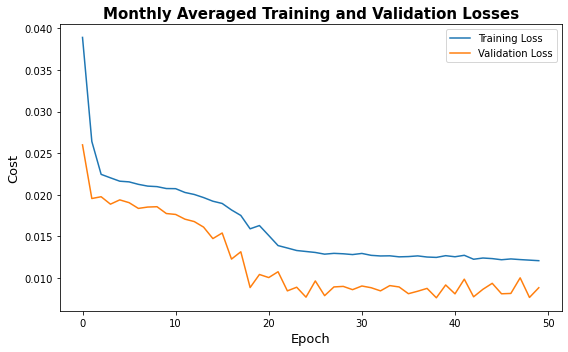

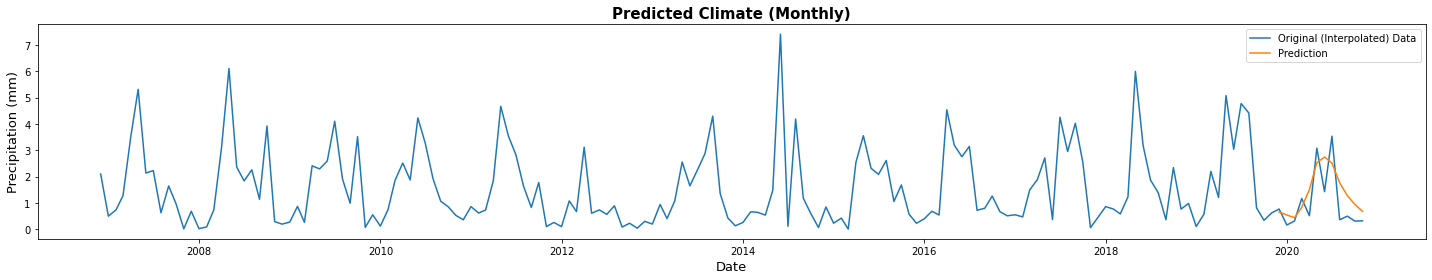

In [ ]:
monthly_prcp_pred2 = predict(36,120,monthly_prcp,avgs=True,normalised=True) # PRCP climate prediction in 10 years
prediction_plots(days3,prcp,prcp_pred1,months3,monthly_prcp,monthly_prcp_pred2,'Precipitation (mm)') # Prediction plots

### SNWD

1/1 [==============================] - 1s 561ms/step


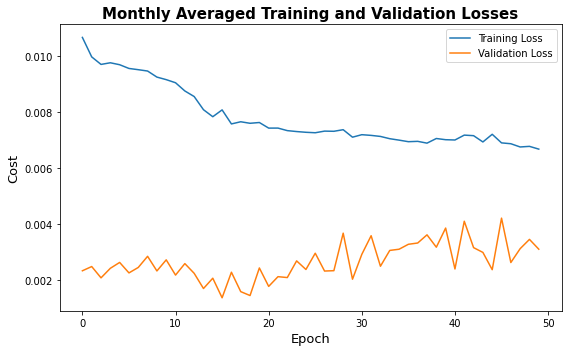

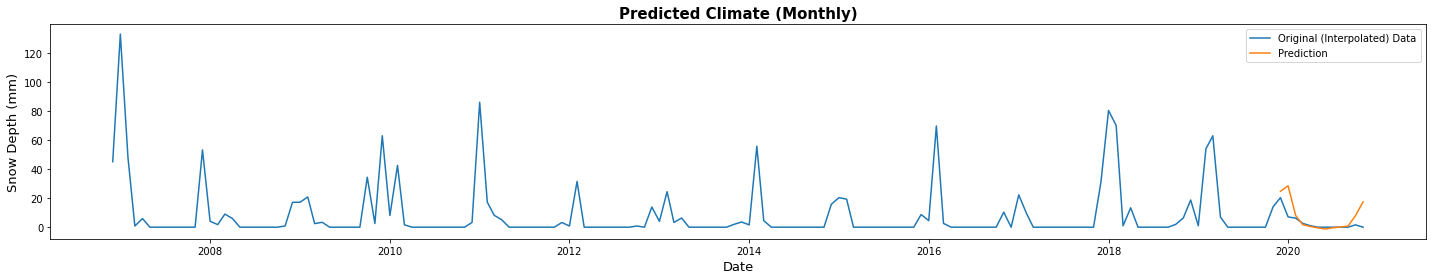

In [ ]:
monthly_snwd_pred2 = predict(36,120,monthly_snwd,avgs=True,normalised=True) # SNWD climate prediction in 10 years
prediction_plots(days4,snwd,snwd_pred1,months4,monthly_snwd,monthly_snwd_pred2,'Snow Depth (mm)') # Prediction plots

### SNOW

1/1 [==============================] - 0s 480ms/step


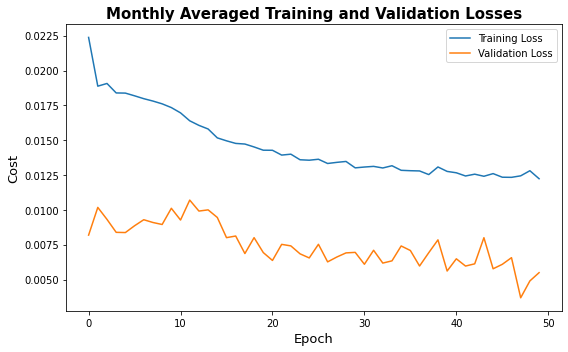

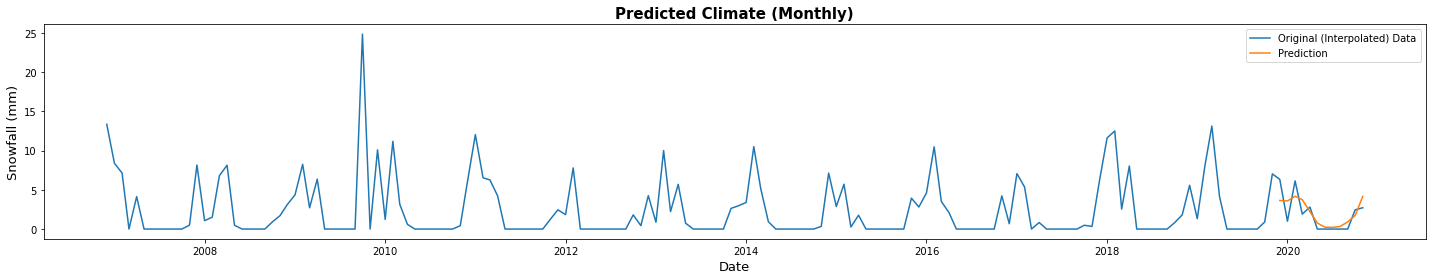

In [ ]:
monthly_snow_pred2 = predict(36,120,monthly_snow,avgs=True,normalised=True) # SNOW climate prediction in 10 years
prediction_plots(days5,snow,snow_pred1,months5,monthly_snow,monthly_snow_pred2,'Snowfall (mm)') # Prediction plots

### Conclusions
The predictions are similar to the forecasts produced previously for the climate in one years time. A noteable discrepancy is the observation of the reduced maximums and minimums the network predicts compared to the original data when predicting 10 years ahead, a possible indication of rapid global warming.

Overall a neural network was able to predict the future weather and climate of a chosen station from the GHCN to some accuracy and success. The performance varied between metrics, with forecasts of ***TMAX*** and ***TMIN*** being particularly good whereas the model was unable to produce the same standard of prediction for other metrics, noteably ***PRCP***.

Perhaps further modifications to the training process including the adjustment of batch size, epoch count, number of LSTM layers and dense layers may lead the network to enhance its performance, although preliminary experimentation on these factors did not show much improvement.

## Bibliography
[1] Nichol, R. (2023) "Week6_pandas.ipynb", Available at: https://colab.research.google.com/github/nichol77/mlForPhysicists/blob/master/Week6/Week6_pandas.ipynb

[2] Makwana, D. (2023) "Week_6_Exercise.ipynb", Available at: https://moodle.ucl.ac.uk/pluginfile.php/5455057/assignsubmission_file/submission_files/2537451/Week_6_Exercise.ipynb?forcedownload=1